<a href="https://colab.research.google.com/github/DPonirakis/pyNoiseAnalyzer/blob/main/pam2pyBroadband.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Computes calibrated acoustic spectra from (lossless) digital audio files.
# Adapted from PG_Func.m, by Nathan D. Merchant

#WAV format             Min       Max        NumPy dtype
#32-bit floating-point -1.0      +1.0        float32
#32-bit integer PCM  -2147483648 +2147483647 int32
#24-bit integer PCM  -2147483648 +2147483392 int32
#16-bit integer PCM  -32768      +32767      int16
# 8-bit integer PCM   0           255        uint8

import numpy as np
import scipy as sp
import soundfile as sf
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [ ]:
#======================================================================
A = []
f = []
t = []
#======================================================================
S = 0.0
olap = 0.5

In [ ]:
thesignal, Fs = sf.read('/content/drive/MyDrive/SoundData/PAMguide/WhiteNoise_10s_48kHz_+-0.5.wav',dtype=np.float64) # Let's hope we always get -1 < thedata < 1

wlength = 1

In [ ]:
samples_channels = np.squeeze( thesignal.shape )
if samples_channels.size == 1:
    samples  = samples_channels
    channels = 1
    xbit     = thesignal; thesignal = []
else:
    samples  = samples_channels[0]
    channels = samples_channels[1]
    xbit     = thesignal[0,:]; thesignal = []

In [ ]:
xbit = np.float32( xbit ) # Single precision
nyquist = int( Fs/2 )
N = int( Fs*wlength )

#Mh = -36-120
Mh = -200
#Vadc = 1.414
Vadc = 2
#G = 0
G = 0

lcut = 1
hcut = nyquist

winname = 'Hann'

#pref = 20
pref = 1

In [ ]:
S = Mh + G + 20*np.log10(1/Vadc)


In [ ]:
xl = len(xbit)



# Mimic MATLAB routine to generate buffer array

In [ ]:
def buffer(X, n, p=0, opt=None):
    '''Mimic MATLAB routine to generate buffer array

    MATLAB docs here: https://se.mathworks.com/help/signal/ref/buffer.html

    Parameters
    ----------
    x: ndarray
        Signal array
    n: int
        Number of data segments
    p: int
        Number of values to overlap
    opt: str
        Initial condition options. default sets the first `p` values to zero,
        while 'nodelay' begins filling the buffer immediately.

    Returns
    -------
    result : (n,n) ndarray
        Buffer array created from X
    '''

    n = int(n)

    import numpy as np

    if opt not in [None, 'nodelay']:
        raise ValueError('{} not implemented'.format(opt))

    i = 0
    first_iter = True
    while i < len(X):
        if first_iter:
            if opt == 'nodelay':
                # No zeros at array start
                result = X[:n]
                i = n
            else:
                # Start with `p` zeros
                result = np.hstack([np.zeros(p), X[:n-p]])
                i = n-p
            # Make 2D array and pivot
            result = np.expand_dims(result, axis=0).T
            first_iter = False
            continue

        # Create next column, add `p` results from last col if given
        col = X[i:i+int(np.floor(n-p))]
        if p != 0:
            col = np.hstack([result[:,-1][-p:], col])
        i += n-p

        # Append zeros if last row and not length `n`
        if len(col) < n:
            col = np.hstack([col, np.zeros(n-len(col))])

        # Combine result with next row
        result = np.hstack([result, np.expand_dims(col, axis=0).T])

    return result

In [ ]:
#xbit[N:]
np.ceil(N*olap)
xgrid = buffer(xbit,N,int(np.ceil(N*olap)),'nodelay')
xgrid = np.transpose(xgrid)

np.shape(xgrid)


(19, 48000)

In [ ]:
M = len(xgrid[:,1])
M

19

# Equation (6) - Create a Hann Window

In [ ]:
#create a Hann window

w = (0.5 - 0.5*np.cos(2*np.pi*np.linspace(1,N,N)/N))
alpha = 0.5 #scaling factor

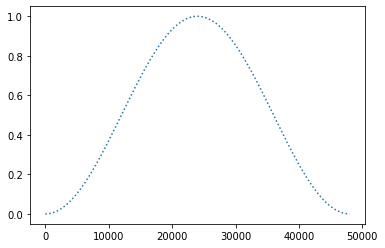

In [ ]:
import matplotlib.pyplot as plt

plt.plot(w, linestyle = 'dotted')
plt.show()

# Multiply Segments by Window Function (Hann)

In [ ]:
xgrid = xgrid*np.tile(w/alpha,[M,1])

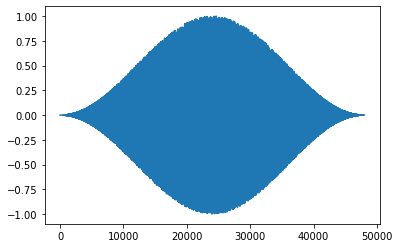

In [ ]:
plt.plot(xgrid[M-1,:], linestyle = '-')
plt.show()

# Equation (7) - Compute DFT

In [35]:
X = abs(sp.fft.fft(xgrid))

np.shape(X)

(19, 48000)

# Equation (8) - Compute Power Spectrum


In [36]:
P = (X/N)**2;                      #power spectrum = square of amplitude

np.shape(P)

(19, 48000)

# Equation (9) - Compute single-sided power spectrum

remove DC (0 Hz) component and 
frequencies above Nyquist frequency
Fs/2 (index of Fs/2 = N/2+1), divide
by noise power bandwidth

In [37]:
Pss = 2*P[:,1:int(np.floor(N/2)+1)]

np.shape(Pss)

(19, 24000)

# compute frequencies of DFT bins

In [38]:
f = np.floor(Fs/2)*np.linspace(1/(N/2),1,int(N/2))

f

np.shape(f)

(24000,)

In [39]:
flow = np.where((f >= lcut) & (f<=hcut))
f = f[flow]
nf = len(f)
nf

24000

# Compute noise power bandwidth and delta(f)

In [40]:
B = (1/N)*(np.sum((w/alpha)**2))
delf = Fs/N

print(B)

1.5


In [41]:
print(flow[0])

[    0     1     2 ... 23997 23998 23999]


# Equation (17) - Convert to dB [Broadband]



In [42]:
a = 10*np.log10(np.sum(Pss[:,flow],2)/(pref**2))-S
a

array([[196.95670066],
       [197.03273978],
       [197.01293063],
       [197.00300977],
       [197.00089877],
       [196.9795756 ],
       [196.99417717],
       [196.96083291],
       [197.02834029],
       [196.97382791],
       [197.02253275],
       [197.00338762],
       [196.96701469],
       [197.00776351],
       [196.99800037],
       [197.0043502 ],
       [196.99876259],
       [196.96904126],
       [196.98255289]])

# Compute Time Vector

In [43]:
tint = (1-olap)*N/Fs
ttot = M*tint-tint
t = np.linspace(0,ttot,int(ttot/tint+1))
t

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. ])

# Construct and output array

In [44]:
a = np.ndarray.flatten(a)
A = np.column_stack((t,np.around(a,1)))

print(A)

[[  0.  197. ]
 [  0.5 197. ]
 [  1.  197. ]
 [  1.5 197. ]
 [  2.  197. ]
 [  2.5 197. ]
 [  3.  197. ]
 [  3.5 197. ]
 [  4.  197. ]
 [  4.5 197. ]
 [  5.  197. ]
 [  5.5 197. ]
 [  6.  197. ]
 [  6.5 197. ]
 [  7.  197. ]
 [  7.5 197. ]
 [  8.  197. ]
 [  8.5 197. ]
 [  9.  197. ]]


# Plot the Data

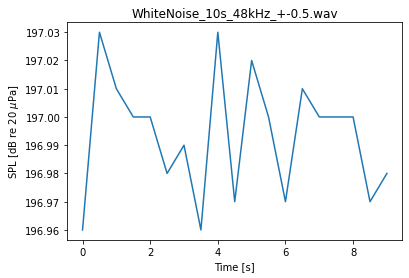

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


ax.plot(t,np.around(a,2))
ax.ticklabel_format(useOffset=False)

plt.xlabel('Time [s]')
plt.ylabel(r'SPL [dB re 20 $\mu$Pa]')
plt.title('WhiteNoise_10s_48kHz_+-0.5.wav')

plt.show()